# Computer Vision Tennis Forehand Classifier
## Student Name: Ayan Mahmood
## Stevens ID: amahmoo3@stevens.edu

## Preface: The tennis forehand is a more complex and detailed shot than many think. There are many specific actions that need to be done in order to have a good forehand shot form. It is not as simple as just hitting the ball over the net. The good thing about a tennis forehand is that there is universally one formula that a majority of professionals use in order to achieve this perfect forehand shot. This project is important for beginners who would like to improve their tennis skills; when learning tennis it is very easy to form bad habits and hopefully this model will help you realize that you are doing something wrong before you form a bad habit. This project can be further applied to other sports such as a basketball jumpshot or a golf swing.
## -
## -
## -

## There were no datasets that I could find that fit the vision I had for this project so I made my own dataset by clipping and cropping videos from real tennis matches played by professionals, as well as some amateurs who made mistakes on YouTube. 
## The annotations are stored as JSON files and the video clips are stored as .MP4 files
## The annotations are based off of some important factors that make a forehand good. First I would classify whether it is a good shot or bad shot. Then there are 7 features that I had selected that I consider to be important when hitting a good forehnad. These features are stance, contact point, follow through, footwork, readiness, ball speed, and distance from the ball. While these are not all the important things that determine whether a forehand is good or bad, it is good enough to determine whether someone hit a good shot or not. 
## -
## This project was done in three phases, the first part I thought I can just feed an LSTM model my videos and annotations and expect a decent accuracy. The second phase I realized the mistake with the first approach and tried to improve the model and its accuracy. The third and final phase I incorporated the features to the phase two model.

# PHASE 1:

In [1]:
import os
import numpy as np
import cv2
import json
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-04-28 17:01:56.925365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loads the videos and labels and puts it into a training and testing set to be input into the model
### Notice that the features are not being utilized and that it is based only off the good or bad shot quality, that is becuase I wanted to first see if it would work before implementing the features.

In [9]:
def load_videos_and_labels(video_folder, label_folder, frame_count=110):
    videos = []
    labels = []
    video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
    for video_file in video_files:
        video_path = os.path.join(video_folder, video_file)
        label_path = os.path.join(label_folder, video_file.replace('.mp4', '.json'))
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        skip = max(1, total_frames // frame_count)
        
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % skip == 0:
                frames.append(cv2.resize(frame, (224, 224)))
            frame_idx += 1
            if len(frames) == frame_count:
                break
        frames += [frames[-1]] * (frame_count - len(frames))
        videos.append(np.array(frames) / 255.0)
        cap.release()
        
        with open(label_path, 'r') as file:
            data = json.load(file)
            labels.append(1 if data['shot_quality'] == 'good' else 0)
            
    return np.array(videos), np.array(labels)

video_folder = '../videos'
label_folder = '../annotations'
X, y = load_videos_and_labels(video_folder, label_folder)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## I used an LSTM model at first because it is good at learning sequential data and learning those patterns.

In [7]:
model = Sequential([
    TimeDistributed(VGG16(weights='imagenet', include_top=False), input_shape=(None, 224, 224, 3)),
    TimeDistributed(Flatten()),
    LSTM(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## This model training worked before but I will not be rerunning it because it takes 3 hours almost
## I had accidentaly ran it again causing the output to go away but the testing evaluation is still there

In [2]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

NameError: name 'model' is not defined

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

1/1 [==============================] - 24s 24s/step - loss: 95106.0625 - accuracy: 0.6667
Test accuracy: 0.6666666865348816, Test loss: 95106.0625


## With a 66.67% accuracy I felt that the model could be improved and I wanted to build a very good model so I did some investigating. Also the loss was very high so I knew something was definitely up.
### -
### -


## The function below was helped created by ChatGPT and it allows me to view the frames of the video. 
## I needed to see whether the corect frames were being input and evidently some videos did not have the correct framing.

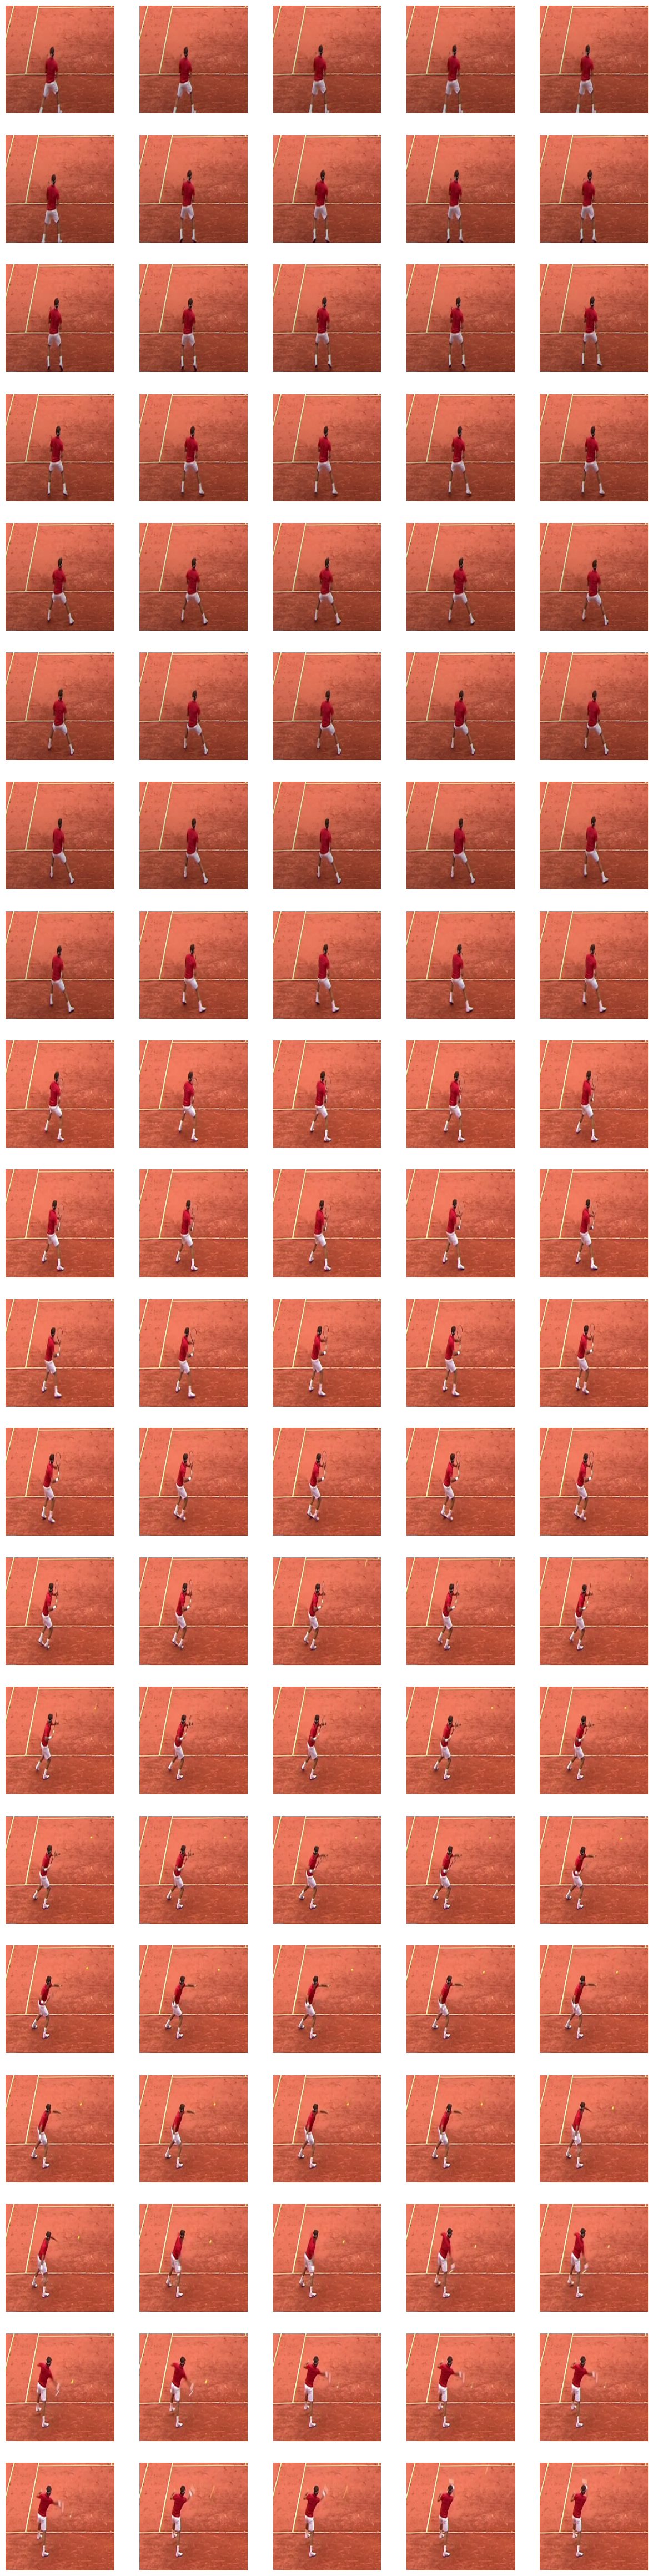

In [31]:
def display_video_frames(video_path, frame_count=100, frames_to_display=100):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(1, total_frames // frame_count)

    frames = []
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % skip == 0:
            frame_resized = cv2.resize(frame, (224, 224))
            frames.append(frame_resized)
            if len(frames) == frame_count:
                break
        frame_idx += 1

    cap.release()

    # Displaying the frames
    cols = 5  # Number of columns in the plot grid
    rows = (frames_to_display + cols - 1) // cols  # Calculate the required number of rows
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))  # Adjust size as needed
    axs = axs.ravel() if rows > 1 else [axs]  # Handle the case of a single row

    for i in range(min(frames_to_display, len(frames))):
        axs[i].imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
        axs[i].axis('off')
    for i in range(min(frames_to_display, len(frames)), len(axs)):
        axs[i].axis('off')

    plt.show()

# Example usage
video_folder = '../videos'
sample_video = 'video_a3.mp4'
display_video_frames(os.path.join(video_folder, sample_video))

## This function below was extremely important and helpful in the selection of frames, it allowed me to analyze the videos frame by frame and select the relevant portions of the videos.

In [11]:
def manual_frame_selection_and_save(video_path, output_folder, base_filename):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # Create output directory if it does not exist

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            cv2.imshow('Frame - Press s to save, q to quit, any other key to continue', frame)
            key = cv2.waitKey(0) & 0xFF

            if key == ord('s'):
                frame_filename = f"{base_filename}_{saved_count+1:03d}.png"
                frame_path = os.path.join(output_folder, frame_filename)
                cv2.imwrite(frame_path, frame)
                print(f"Saved: {frame_path}")
                saved_count += 1
            elif key == ord('q'):
                break

            frame_count += 1
    finally:
        cap.release()
        cv2.destroyAllWindows()

    print(f"Total frames checked: {frame_count}, frames saved: {saved_count}")

# Example usage
video_folder = '../videos'
output_folder = '../frames/video_e1'  # Adjust as needed for each video
video_filename = 'video_e1.mp4'
video_path = os.path.join(video_folder, video_filename)
base_filename = 'video_e1_frame'

manual_frame_selection_and_save(video_path, output_folder, base_filename)

Saved: ../frames/video_e1/video_e1_frame_001.png
Saved: ../frames/video_e1/video_e1_frame_002.png
Saved: ../frames/video_e1/video_e1_frame_003.png
Saved: ../frames/video_e1/video_e1_frame_004.png
Saved: ../frames/video_e1/video_e1_frame_005.png
Saved: ../frames/video_e1/video_e1_frame_006.png
Saved: ../frames/video_e1/video_e1_frame_007.png
Saved: ../frames/video_e1/video_e1_frame_008.png
Saved: ../frames/video_e1/video_e1_frame_009.png
Saved: ../frames/video_e1/video_e1_frame_010.png
Saved: ../frames/video_e1/video_e1_frame_011.png
Saved: ../frames/video_e1/video_e1_frame_012.png
Saved: ../frames/video_e1/video_e1_frame_013.png
Saved: ../frames/video_e1/video_e1_frame_014.png
Saved: ../frames/video_e1/video_e1_frame_015.png
Saved: ../frames/video_e1/video_e1_frame_016.png
Saved: ../frames/video_e1/video_e1_frame_017.png
Saved: ../frames/video_e1/video_e1_frame_018.png
Saved: ../frames/video_e1/video_e1_frame_019.png
Saved: ../frames/video_e1/video_e1_frame_020.png
Saved: ../frames/vid

# PHASE 2:

## Once I had realized that in phase 1 not every video had the correct focus of frames, I had to select the correct frames for each video which I did above. 
## The following function loads the frames with the annotation data and prepares it for the model

In [2]:
def load_data(frames_folder, annotations_folder):
    data = []
    labels = []

    # Loop through each video's frame folder
    for video_folder in sorted(os.listdir(frames_folder)):
        video_frames_folder = os.path.join(frames_folder, video_folder)
        frames = [cv2.imread(os.path.join(video_frames_folder, frame))
                  for frame in sorted(os.listdir(video_frames_folder))
                  if frame.endswith('.png')]

        # Load corresponding annotation
        annotation_path = os.path.join(annotations_folder, video_folder + '.json')
        with open(annotation_path, 'r') as file:
            annotation = json.load(file)
            label = 1 if annotation['shot_quality'] == 'good' else 0

        # Append each frame and label to the data list
        for frame in frames:
            data.append(cv2.resize(frame, (224, 224)))  # Resize frames if necessary
            labels.append(label)

    return np.array(data), np.array(labels)

# Example usage
frames_folder = '../frames'
annotations_folder = '../annotations'
X, y = load_data(frames_folder, annotations_folder)

In [3]:
X = X.astype('float32') / 255.0

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## This time now that I had changed the way the data is - frames of images instead of videos - I needed to change the model to better reflect the data. The comments in the code below explain the model but basically it is a convolutional neural network with two convolutional layers.

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)), #first convolution layer with 32 filters and 3x3 kernel size
    MaxPooling2D(2, 2), #max pooling layer with 2x2 pool size to reduce the spatial dimensions of the output volume
    Conv2D(64, (3, 3), activation='relu'), #second convolution layer with 64 filters and 3x3 kernel size
    MaxPooling2D(2, 2), #further reduce the spatial dimensions of the volume
    Flatten(), #need to flatten the volume to feed it into the dense layers
    Dense(64, activation='relu'), #fully connected layer with 64 neurons
    Dense(1, activation='sigmoid') #output layer with 1 neuron and sigmoid activation function to create a probability score
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [6]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
39/39 [==============================] - 42s 990ms/step - loss: 0.7616 - accuracy: 0.8108 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 2/10
39/39 [==============================] - 38s 960ms/step - loss: 0.0055 - accuracy: 0.9992 - val_loss: 7.5072e-04 - val_accuracy: 1.0000
Epoch 3/10
39/39 [==============================] - 37s 946ms/step - loss: 5.3720e-04 - accuracy: 1.0000 - val_loss: 3.3150e-04 - val_accuracy: 1.0000
Epoch 4/10
39/39 [==============================] - 37s 948ms/step - loss: 2.7399e-04 - accuracy: 1.0000 - val_loss: 2.1266e-04 - val_accuracy: 1.0000
Epoch 5/10
39/39 [==============================] - 37s 947ms/step - loss: 1.8811e-04 - accuracy: 1.0000 - val_loss: 1.5756e-04 - val_accuracy: 1.0000
Epoch 6/10
39/39 [==============================] - 40s 1s/step - loss: 1.2773e-04 - accuracy: 1.0000 - val_loss: 1.0269e-04 - val_accuracy: 1.0000
Epoch 7/10
39/39 [==============================] - 42s 1s/step - loss: 8.8540e-05 - accuracy: 1.0000 - val_l

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

26/26 [==============================] - 6s 243ms/step - loss: 3.4563e-05 - accuracy: 1.0000
Test accuracy: 1.0, Test loss: 3.45632251992356e-05


## The test accuracy being a perfect 100% and the loss being extremely low I had thought "oh wow this model is too good to be true", some possible reasons for this are overfitting the model on the dataset. Another possibility is that the dataset is relatively small.
## -
## -
## -

# PHASE 3:
## The previous model was only classifying based off of the good or bad labels so I wanted to incorporate the rest of the annotation features into the model to see if that would enhance the model and accuracy.
### Below is the third and final part of this project where I create a model based on the features to see whether it is able to accurately predict good or bad forehands.

In [1]:
import os
import numpy as np
import cv2
import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define feature encoding for categorical data globally
feature_encoding = {
        'stance': {'open': 0, 'wide': 1},
        'contact_point': {'in front': 0, 'on side': 1},
        'follow_through': {'complete': 0, 'incomplete': 1},
        'footwork': {'balanced': 0, 'off balance': 1},
        'readiness': {'ready': 0, 'not ready': 1},
        'ball_speed': {'high': 0, 'low': 1},
        'distance_from_ball': {'good': 0, 'poor': 1}
}

2024-04-28 15:36:57.288142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Process the data and features into numpy arrays and make it ready to be input into the model.

In [2]:
def load_data_with_features(frames_folder, annotations_folder):
    data = []
    labels = []
    features = []

    for video_folder in sorted(os.listdir(frames_folder)):
        video_frames_folder = os.path.join(frames_folder, video_folder)
        frame_files = sorted([f for f in os.listdir(video_frames_folder) if f.endswith('.png')])
        frames = [cv2.imread(os.path.join(video_frames_folder, f)) for f in frame_files]
        frames = [cv2.resize(frame, (224, 224)) for frame in frames if frame is not None]

        annotation_path = os.path.join(annotations_folder, video_folder + '.json')
        with open(annotation_path, 'r') as file:
            annotation = json.load(file)
        label = 1 if annotation['shot_quality'] == 'good' else 0
        frame_features = [feature_encoding[key][annotation['features'][key]] for key in feature_encoding]

        for frame in frames:
            data.append(frame)
            labels.append(label)
            features.append(frame_features)

    return np.array(data), np.array(labels), np.array(features)

# Ensure data is loaded correctly
frames_folder = '../frames'
annotations_folder = '../annotations'
X, y, feature_data = load_data_with_features(frames_folder, annotations_folder)
X = X.astype('float32') / 255.0  # Normalize pixel values
print("Data shapes:", X.shape, y.shape, feature_data.shape)


Data shapes: (2215, 224, 224, 3) (2215,) (2215, 7)


# Model fitting with features:
### This time it is a multi-input model that processes image data and numerical feauture data. These inputs are processes separately through different layers and then combined to make the final prediction. 

Epoch 1/10
42/42 [==============================] - 46s 1s/step - loss: 0.4422 - accuracy: 0.8653 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 2/10
42/42 [==============================] - 43s 1s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.0827e-04 - val_accuracy: 1.0000
Epoch 3/10
42/42 [==============================] - 40s 962ms/step - loss: 8.8945e-05 - accuracy: 1.0000 - val_loss: 4.3183e-05 - val_accuracy: 1.0000
Epoch 4/10
42/42 [==============================] - 39s 940ms/step - loss: 3.0175e-05 - accuracy: 1.0000 - val_loss: 2.9505e-05 - val_accuracy: 1.0000
Epoch 5/10
42/42 [==============================] - 41s 979ms/step - loss: 1.6925e-05 - accuracy: 1.0000 - val_loss: 1.2871e-05 - val_accuracy: 1.0000
Epoch 6/10
42/42 [==============================] - 41s 969ms/step - loss: 7.7174e-06 - accuracy: 1.0000 - val_loss: 5.8323e-06 - val_accuracy: 1.0000
Epoch 7/10
42/42 [==============================] - 40s 959ms/step - loss: 3.4412e-06 - accuracy: 1.0000 - val_l

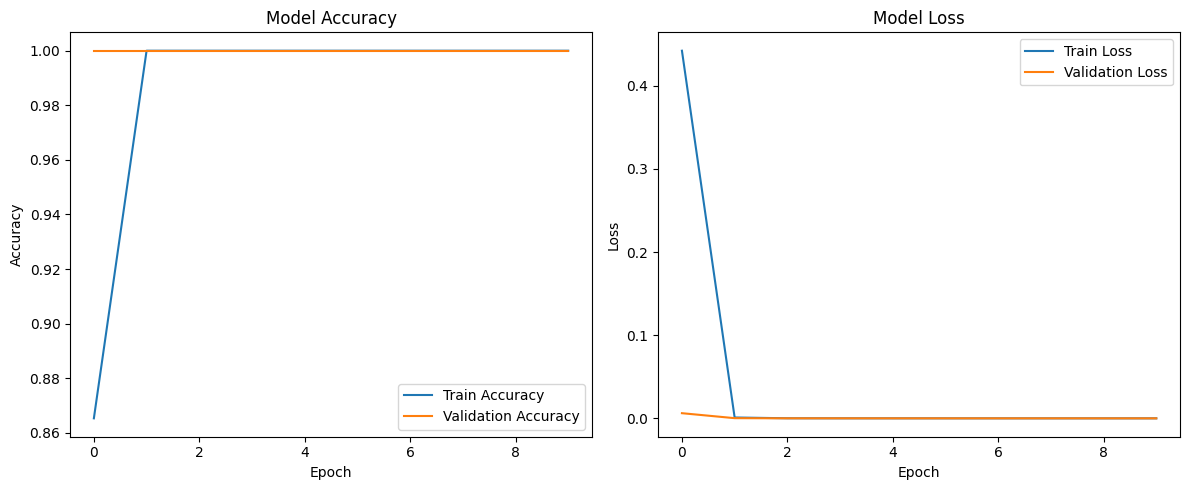

In [3]:
img_input = Input(shape=(224, 224, 3)) #image input data, 224 pixel by 224 pixel with 3 channels RGB
x = Conv2D(32, (3, 3), activation='relu')(img_input) #convolutional layer with 32 filters and 3x3 kernel size
x = MaxPooling2D(2, 2)(x) #max pooling layer with 2x2 pool size, reduces the number of parameters and computations in the network
x = Conv2D(64, (3, 3), activation='relu')(x) #second convolutional layer with 64 filters and 3x3 kernel size based on the output of the previous layer
x = MaxPooling2D(2, 2)(x) #second max pooling layer, further reduces the dimesions of the data
x = Flatten()(x) #need to flatten the data before passing it to the dense layer
img_output = Dense(64, activation='relu')(x) #fully connected layer with 64 neurons and relu activation function

features_input = Input(shape=(7,)) #input layer for the features, 7 features per input
y_layer = Dense(32, activation='relu')(features_input) #fully connected layer with 32 neurons and relu activation function, processes the 7 features
features_output = Dense(16, activation='relu')(y_layer) #further process the features with 16 neurons and relu activation function

combined = concatenate([img_output, features_output]) #combine the image and feature data
z = Dense(1, activation='sigmoid')(combined) #outputs the probability of the shot being good or bad

model = Model(inputs=[img_input, features_input], outputs=z)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compile the model with adam optimizer and binary crossentropy loss function

# Prepare for training
from sklearn.model_selection import train_test_split
X_train, X_test, features_train, features_test, y_train, y_test = train_test_split(X, feature_data, y, test_size=0.20, random_state=42)

# Train the model
history = model.fit([X_train, features_train], y_train, epochs=10, validation_data=([X_test, features_test], y_test))

#plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Here is a function to test on completely unseen videos that do not even have annotations to test the efficacy of the model. It makes predictions whether the forehand is good or bad just given the video and nothing else

In [7]:
def prepare_frames_only(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, (224, 224))  # Resizing as per model's input requirement
            frames.append(frame_resized)
    finally:
        cap.release()
    
    frames = np.array(frames, dtype='float32') / 255.0  # Normalize pixel values
    return frames

# Example usage
video_path = '../test_video/video_c6.mp4'
frames = prepare_frames_only(video_path)

def prepare_frames_with_default_features(video_path, default_features):
    frames = prepare_frames_only(video_path)
    # Repeat default features for each frame to match the frames' shape
    features = np.tile(default_features, (frames.shape[0], 1))
    return frames, features

# Define default or neutral values for features
default_features = np.array([[0.5] * 7])  # Example with neutral values; adjust as needed

# Prepare data
frames, features = prepare_frames_with_default_features(video_path, default_features)

# Make predictions
predictions = model.predict([frames, features])
predicted_classes = (predictions > 0.5).astype(int)
video_prediction = np.mean(predicted_classes)
print(f"The video is predicted as {'good' if video_prediction > 0.5 else 'bad'} with a confidence of {video_prediction:.2f}")



3/3 [==============================] - 1s 143ms/step
The video is predicted as good with a confidence of 1.00


# I wanted to make sure to test on an unseen test set so I further split the data to be 60% training, 20% validation, and 20% test. Just to make sure.


In [3]:
img_input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
img_output = Dense(64, activation='relu')(x)

features_input = Input(shape=(7,))
y_layer = Dense(32, activation='relu')(features_input)
features_output = Dense(16, activation='relu')(y_layer)

combined = concatenate([img_output, features_output])
z = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[img_input, features_input], outputs=z)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare for training
from sklearn.model_selection import train_test_split

# Split into train+validation and test
X_temp, X_test, features_temp, features_test, y_temp, y_test = train_test_split(
    X, feature_data, y, test_size=0.20, random_state=42)

# Split train+validation into train and validation
X_train, X_val, features_train, features_val, y_train, y_val = train_test_split(
    X_temp, features_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.80 = 0.20

# Now, you have X_train, X_val, X_test, features_train, features_val, features_test, y_train, y_val, y_test
# corresponding to 60%, 20%, 20% splits respectively.


# Train the model using the training set and validate on the validation set
history = model.fit(
    [X_train, features_train], y_train,
    validation_data=([X_val, features_val], y_val),
    epochs=10,
    batch_size=32  # Adjust batch size according to your system capabilities
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/10
42/42 [==============================] - 41s 933ms/step - loss: 0.7145 - accuracy: 0.8277 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 2/10
42/42 [==============================] - 37s 874ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 6.6920e-04 - val_accuracy: 1.0000
Epoch 3/10
42/42 [==============================] - 37s 878ms/step - loss: 3.8752e-04 - accuracy: 1.0000 - val_loss: 3.4459e-04 - val_accuracy: 1.0000
Epoch 4/10
42/42 [==============================] - 37s 876ms/step - loss: 2.2566e-04 - accuracy: 1.0000 - val_loss: 2.3292e-04 - val_accuracy: 1.0000
Epoch 5/10
42/42 [==============================] - 37s 878ms/step - loss: 1.5741e-04 - accuracy: 1.0000 - val_loss: 1.7626e-04 - val_accuracy: 1.0000
Epoch 6/10
42/42 [==============================] - 37s 877ms/step - loss: 1.2551e-04 - accuracy: 1.0000 - val_loss: 1.4119e-04 - val_accuracy: 1.0000
Epoch 7/10
42/42 [==============================] - 41s 971ms/step - loss: 1.0037e-04 - accuracy: 1.0000 -

# Despite splitting the dataset into 60% training, 20% validation, and 20% testing the results remained the same
## The model remains to have a low loss and 100% accuracy. 
## In the future I hope to expand the dataset to account for different camera angles and ignore noisy backgrounds, I would also like to make it be able to analyze backhands and other shots in tennis such as serves or volleys. Then if that is successfull I will want to try branching out to other sports such as Basketball. 

###
###
###
###
## Model without annotations, based solely off images:

In [5]:
import numpy as np
import os
import cv2
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define a function to load image data and labels
def load_data_without_features(frames_folder, annotations_folder):
    data = []
    labels = []

    for video_folder in sorted(os.listdir(frames_folder)):
        video_frames_folder = os.path.join(frames_folder, video_folder)
        frame_files = sorted([f for f in os.listdir(video_frames_folder) if f.endswith('.png')])
        frames = [cv2.imread(os.path.join(video_frames_folder, f)) for f in frame_files]
        frames = [cv2.resize(frame, (224, 224)) for frame in frames if frame is not None]

        annotation_path = os.path.join(annotations_folder, video_folder + '.json')
        with open(annotation_path, 'r') as file:
            annotation = json.load(file)
        label = 1 if annotation['shot_quality'] == 'good' else 0

        for frame in frames:
            data.append(frame)
            labels.append(label)

    return np.array(data), np.array(labels)

# Load data
frames_folder = '../frames'
annotations_folder = '../annotations'
X, y = load_data_without_features(frames_folder, annotations_folder)
X = X.astype('float32') / 255.0  # Normalize pixel values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Define the image-only model
img_input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=img_input, outputs=output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

import numpy as np
import cv2

def prepare_frames_only(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, (224, 224))  # Resizing as per model's input requirement
            frames.append(frame_resized)
    finally:
        cap.release()
    
    frames = np.array(frames, dtype='float32') / 255.0  # Normalize pixel values
    return frames

# Example usage
video_path = '../test_video/video_c6.mp4'
frames = prepare_frames_only(video_path)

# Make predictions using only image data
predictions = model.predict(frames)

# Aggregate predictions to determine the overall classification of the video
video_prediction = np.mean(predictions)
predicted_label = 'good' if video_prediction > 0.5 else 'bad'

print(f"The video is predicted as '{predicted_label}' with a confidence of {video_prediction:.2f}")


Epoch 1/10
56/56 [==============================] - 49s 857ms/step - loss: 0.2918 - accuracy: 0.9453 - val_loss: 3.7127e-04 - val_accuracy: 1.0000
Epoch 2/10
56/56 [==============================] - 47s 839ms/step - loss: 1.3296e-04 - accuracy: 1.0000 - val_loss: 5.5338e-05 - val_accuracy: 1.0000
Epoch 3/10
56/56 [==============================] - 45s 801ms/step - loss: 1.9078e-05 - accuracy: 1.0000 - val_loss: 9.0837e-06 - val_accuracy: 1.0000
Epoch 4/10
56/56 [==============================] - 45s 812ms/step - loss: 5.3215e-06 - accuracy: 1.0000 - val_loss: 4.0156e-06 - val_accuracy: 1.0000
Epoch 5/10
56/56 [==============================] - 835s 15s/step - loss: 2.8070e-06 - accuracy: 1.0000 - val_loss: 2.4993e-06 - val_accuracy: 1.0000
Epoch 6/10
56/56 [==============================] - 1051s 19s/step - loss: 1.8195e-06 - accuracy: 1.0000 - val_loss: 1.7144e-06 - val_accuracy: 1.0000
Epoch 7/10
56/56 [==============================] - 48s 858ms/step - loss: 1.3866e-06 - accuracy: 1